# Data Cleaning and Precessing

In [1]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.simplefilter(action='ignore')
from matplotlib.ticker import FuncFormatter
from sklearn.utils import resample
from sklearn import set_config
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.metrics import accuracy_score as acc

#read Excel file
original_data = pd.read_excel("/Users/zihaowang/Dropbox/UCI/Fall2020/BANA273/HealthCareData1111.xlsx")

In [2]:
#create response: calculate if readmitted
original_data['dis_date'] = original_data['nrd_daystoevent'] + original_data['los']
sorted_data = original_data.sort_values(by=['hosp_nrd', 'nrd_visitlink','nrd_daystoevent'])
sorted_data['lagged_dis_date'] = sorted_data.groupby(['hosp_nrd', 'nrd_visitlink'])['dis_date'].shift(1)
sorted_data['days_to_comeback'] = sorted_data['nrd_daystoevent'] - sorted_data['lagged_dis_date']
sorted_data['if_readmitted'] = np.where(sorted_data['days_to_comeback'] <= 30, 1,0)

In [3]:
#filter out patients who died
sorted_data = sorted_data[sorted_data['died'] == 0] 
sorted_data = sorted_data[sorted_data['dispuniform'] != 20] 

#filter out patients who were age at 0
sorted_data = sorted_data[sorted_data['age'] != 0] 

#filter out patients who transfer
sorted_data = sorted_data[sorted_data['dispuniform'] != 2]
sorted_data = sorted_data[sorted_data['dispuniform'] != 5]

#filter out patients who Left Against Medical Advice or Discontinued Care
sorted_data = sorted_data[sorted_data['dispuniform'] != 7]

#filter out patients who discharged by Court/Law Enforcement
sorted_data = sorted_data[sorted_data['dispuniform'] != 21]

In [4]:
#drop useless variable
sorted_data = sorted_data.drop(columns=['key_nrd', 'hosp_nrd', 'nrd_visitlink', 'nrd_daystoevent', 'died', 'dis_date', 'lagged_dis_date', 'days_to_comeback', 'dx1'])

In [5]:
#deal with missing value
#print(sorted_data.info()) #this shows we have missing value in primary_payer, median_hh_income

#simply drop missing value in primary_payer
sorted_data = sorted_data[sorted_data['pay1'].notna()]
#print(sorted_data.info())

#replace the missing value of medianb_hh_income with average value
sorted_data['zipinc_qrtl'].fillna((sorted_data['zipinc_qrtl'].mean()), inplace=True)

In [6]:
#rename columns for readable labels
#mdc: Major Diagnostic Category in effect on discharge date
#pay1: the expected primary payer (Medicare, Medicaid, private insurance, etc.)
cleaned_data = sorted_data.rename(columns={'dispuniform': 'disposition_at_disc',
                                           'female': 'if_female',
                                           'age': 'age_at_admit',
                                           'hosp_bedsize': 'hosp_bedsize',
                                           'h_contrl': 'hosp_ownership',
                                           'hosp_urcat4': 'hosp_urb_rul_designation',
                                           'hosp_ur_teach': 'hosp_teaching_stus',
                                           'aweekend': 'if_weekend_at_admit',
                                           'dmonth': 'disc_month',
                                           'hcup_ed': 'if_emergency_dept',
                                           'los': 'lenght_of_stay',
                                           'mdc': 'mdc_at_disc',
                                           'nchronic':'num_of_chronic_at_disc',
                                           'pay1': 'primary_payer',
                                           'totchg': 'tot_charge_usd',
                                           'zipinc_qrtl': 'median_hh_income',
                                           'aprdrg_risk_mortalit': 'dying_prob',
                                           'aprdrg_severity': 'loss_function_prob'})

cleaned_data
#print(data_rename.info()) #to check out if there is missing value

,index,disposition_at_disc,age_at_admit,hosp_bedsize,hosp_ownership,hosp_urb_rul_designation,hosp_teaching_stus,if_female,if_weekend_at_admit,disc_month,if_emergency_dept,lenght_of_stay,mdc_at_disc,num_of_chronic_at_disc,primary_payer,tot_charge_usd,median_hh_income,dying_prob,loss_function_prob,if_readmitted
21169,433891,1.0,56,2,3,2,0,1,0,8,1,5,6,1,3.0,66343,3.0,2,1,0
12328,249835,1.0,78,2,3,2,0,0,0,10,0,2,8,3,1.0,83212,4.0,1,1,0
7960,160863,1.0,36,2,3,2,0,0,0,4,1,2,6,8,2.0,55915,4.0,2,3,0
26132,532587,1.0,36,2,3,2,0,0,0,4,1,1,4,8,2.0,22174,4.0,1,2,1
1144,22680,1.0,32,2,3,2,0,1,0,3,0,2,5,4,2.0,103386,4.0,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18465,377968,1.0,48,2,2,1,1,0,0,5,1,2,5,7,1.0,22634,2.0,2,2,1
24939,509173,1.0,84,2,2,1,1,1,0,6,1,8,7,4,2.0,58448,2.0,3,3,0
15088,308464,6.0,70,2,2,1,1,1,0,7,1,5,10,9,1.0,42953,1.0,2,2,0
5180,104898,1.0,70,2,2,1,1,1,0,7,1,1,10,2,1.0,9622,1.0,1,2,1


In [7]:
#check readmitted percentage/check if imbalanced data
cleaned_data['if_readmitted'].value_counts(normalize=True) 

0    0.916647
1    0.083353
Name: if_readmitted, dtype: float64

# Data Visulization

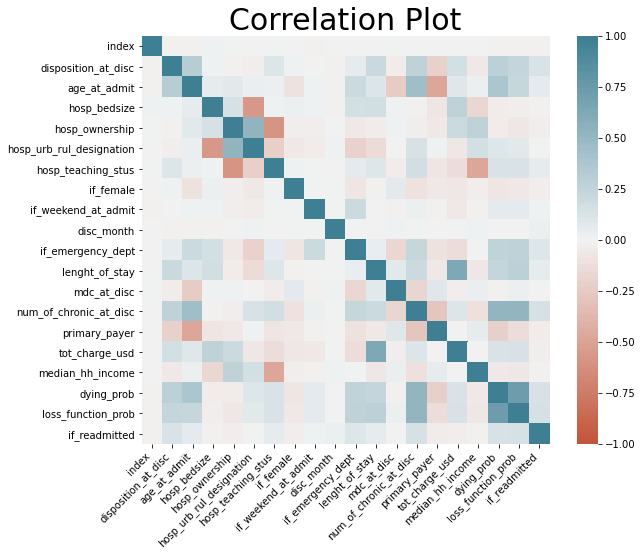

In [8]:
#correlation plot
corr = cleaned_data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, xticklabels=True, yticklabels=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

ax.set_title('Correlation Plot',fontsize=30)
ax.figure.set_figwidth(10)
ax.figure.set_figheight(7.5)

#some high correlation predictors:
#1. tot_charge_usd - length_of_stay (high positive)
#2. median_hh_income - hosp_teaching_status (high negtive)
#3. primary_payer - age_at_admitted (high negtive)
#4. days_to_comeback - disc_month (high positive)

<AxesSubplot:ylabel='age_at_admit'>

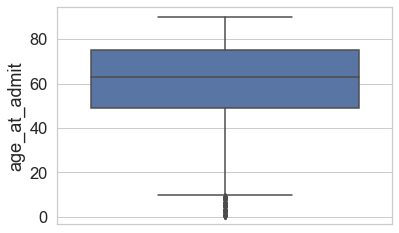

In [9]:
#outlier detection
sns.set(style="whitegrid", font_scale=1.5)
sns.boxplot( y= cleaned_data["age_at_admit"])

<AxesSubplot:ylabel='tot_charge_usd'>

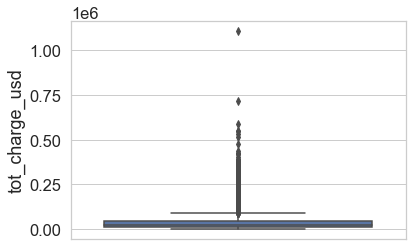

In [10]:
sns.set(style="whitegrid", font_scale=1.5)
sns.boxplot( y= cleaned_data["tot_charge_usd"])

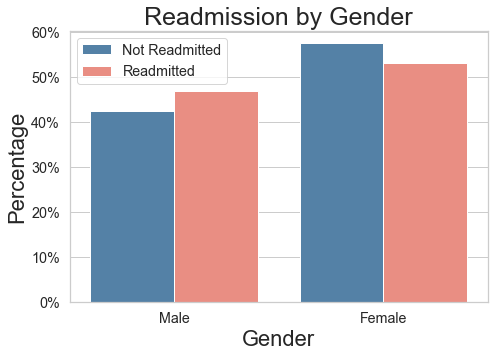

In [11]:
#readmission plot by Gender
grouped_df = cleaned_data.groupby(['if_female', 'if_readmitted']).agg({'if_readmitted': 'count'})
grouped_df.columns = ['count']
grouped_df = grouped_df.reset_index()

sns.set(style="whitegrid", font_scale=1.3)

grouped_df['percentage'] = np.nan
for x,i in enumerate(grouped_df['if_readmitted']):
    if i == 0:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 19036
    else:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 1731

ax = sns.barplot(data = grouped_df, 
                 x='if_female', y='percentage', hue = 'if_readmitted', 
                 palette = sns.color_palette(palette = ["SteelBlue" , "Salmon"]))
ax.set_title('Readmission by Gender',fontsize=25)
plt.xlabel("Gender",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
labels =  ['Male', 'Female']
ax.set_xticklabels(labels)
ax.figure.set_figwidth(7.5)
ax.figure.set_figheight(5)
labels = ['Not Readmitted', 'Readmitted']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

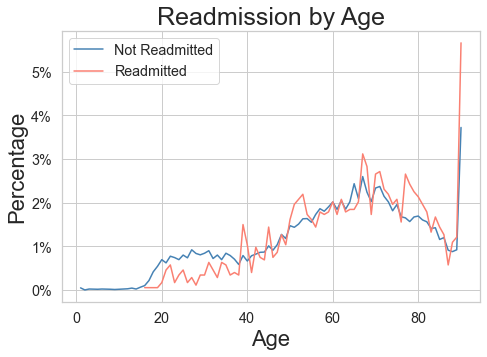

In [12]:
#readmission plot by Age
grouped_df = cleaned_data.groupby(['age_at_admit', 'if_readmitted']).agg({'if_readmitted': 'count'})
grouped_df.columns = ['count']
grouped_df = grouped_df.reset_index()

grouped_df['percentage'] = np.nan
for x,i in enumerate(grouped_df['if_readmitted']):
    if i == 0:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 19036
    else:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 1731

ax = sns.lineplot(data = grouped_df, 
                 x='age_at_admit', y='percentage', hue = 'if_readmitted', 
                 palette = sns.color_palette(palette = ["SteelBlue" , "Salmon"]))
ax.set_title('Readmission by Age',fontsize=25)
plt.xlabel("Age",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
ax.figure.set_figwidth(7.5)
ax.figure.set_figheight(5)
labels = ['Not Readmitted', 'Readmitted']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

In [13]:
c = cleaned_data['if_readmitted'].value_counts()
c

0    19036
1     1731
Name: if_readmitted, dtype: int64

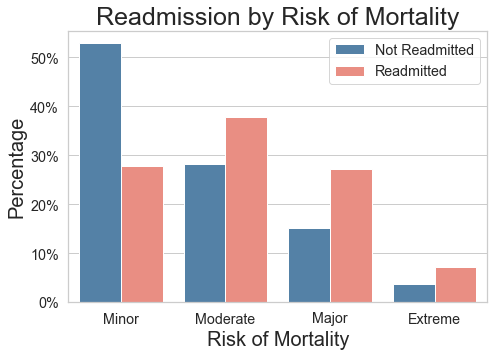

In [14]:
#readmission plot by Diagnosis
grouped_df = cleaned_data.groupby(['dying_prob', 'if_readmitted']).agg({'if_readmitted': 'count'})
grouped_df.columns = ['count']
grouped_df = grouped_df.reset_index()

grouped_df['percentage'] = np.nan
for x,i in enumerate(grouped_df['if_readmitted']):
    if i == 0:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 19036
    else:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 1731

ax = sns.barplot(data = grouped_df, 
                 x='dying_prob', y='percentage', hue = 'if_readmitted', 
                 palette = sns.color_palette(palette = ["SteelBlue" , "Salmon"]))
ax.set_title('Readmission by Risk of Mortality',fontsize=25)
plt.xlabel("Risk of Mortality",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
labels = ['Minor', 'Moderate', 'Major', 'Extreme']
ax.set_xticklabels(labels)
ax.figure.set_figwidth(7.5)
ax.figure.set_figheight(5)
labels = ['Not Readmitted', 'Readmitted']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

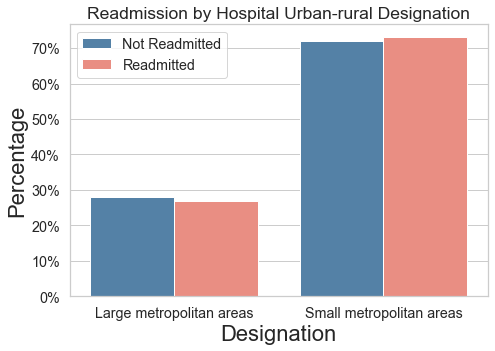

In [15]:
#readmission plot by Hospital Urban-rural Designation
grouped_df = cleaned_data.groupby(['hosp_urb_rul_designation', 'if_readmitted']).agg({'if_readmitted': 'count'})
grouped_df.columns = ['count']
grouped_df = grouped_df.reset_index()

grouped_df['percentage'] = np.nan
for x,i in enumerate(grouped_df['if_readmitted']):
    if i == 0:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 19036
    else:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 1731

ax = sns.barplot(data = grouped_df, 
                 x='hosp_urb_rul_designation', y='percentage', hue = 'if_readmitted', 
                 palette = sns.color_palette(palette = ["SteelBlue" , "Salmon"]))
ax.set_title('Readmission by Hospital Urban-rural Designation',fontsize=17.5)
plt.xlabel("Designation",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
labels = ['Large metropolitan areas', 'Small metropolitan areas']
ax.set_xticklabels(labels)
ax.figure.set_figwidth(7.5)
ax.figure.set_figheight(5)
labels = ['Not Readmitted', 'Readmitted']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

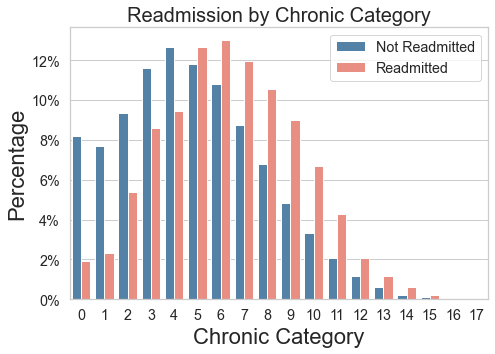

In [16]:
#readmission plot by number of chronic_at_disc
grouped_df = cleaned_data.groupby(['num_of_chronic_at_disc', 'if_readmitted']).agg({'if_readmitted': 'count'})
grouped_df.columns = ['count']
grouped_df = grouped_df.reset_index()

grouped_df['percentage'] = np.nan
for x,i in enumerate(grouped_df['if_readmitted']):
    if i == 0:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 19036
    else:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 1731

ax = sns.barplot(data = grouped_df, 
                 x='num_of_chronic_at_disc', y='percentage', hue = 'if_readmitted', 
                 palette = sns.color_palette(palette = ["SteelBlue" , "Salmon"]))
ax.set_title('Readmission by Chronic Category',fontsize=20)
plt.xlabel("Chronic Category",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
#labels = ['Medicare', 'Medicaid','Private', 'Self-pay','No Charge','Other']
#ax.set_xticklabels(labels)
ax.figure.set_figwidth(7.5)
ax.figure.set_figheight(5)
labels = ['Not Readmitted', 'Readmitted']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

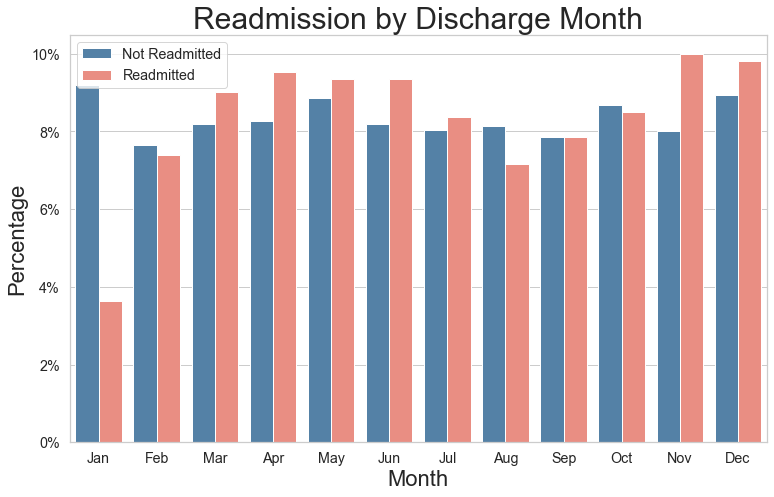

In [17]:
#readmission plot by discharge Month
grouped_df = cleaned_data.groupby(['disc_month', 'if_readmitted']).agg({'if_readmitted': 'count'})
grouped_df.columns = ['count']
grouped_df = grouped_df.reset_index()

grouped_df['percentage'] = np.nan
for x,i in enumerate(grouped_df['if_readmitted']):
    if i == 0:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 19036
    else:
        grouped_df['percentage'][x] = grouped_df['count'][x] / 1731

f, ax = plt.subplots(figsize=(11, 9))
ax = sns.barplot(data = grouped_df, 
                 x='disc_month', y='percentage', hue = 'if_readmitted', 
                 palette = sns.color_palette(palette = ["SteelBlue" , "Salmon"]))
ax.set_title('Readmission by Discharge Month',fontsize=30)
plt.xlabel("Month",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
labels = ['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov','Dec']
ax.set_xticklabels(labels)
ax.figure.set_figwidth(12.5)
ax.figure.set_figheight(7.5)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
labels = ['Not Readmitted', 'Readmitted']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels)

# Benchmark Models

## Resample (Down-sample Majority Class)

In [18]:
# Separate majority and minority classes
df_majority = cleaned_data[cleaned_data.if_readmitted==0]
df_minority = cleaned_data[cleaned_data.if_readmitted==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1731,     # to match minority class
                                 random_state=1) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.if_readmitted.value_counts()

1    1731
0    1731
Name: if_readmitted, dtype: int64

## Logistic Regression

In [19]:
#import the dataset 
X = df_downsampled.iloc[:, :-1].values
y = df_downsampled.iloc[:, -1].values

#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [20]:
#train model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
#accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

[[220 319]
 [120 380]]
              precision    recall  f1-score   support

           0       0.65      0.41      0.50       539
           1       0.54      0.76      0.63       500

    accuracy                           0.58      1039
   macro avg       0.60      0.58      0.57      1039
weighted avg       0.60      0.58      0.56      1039



In [21]:
import numpy as np
from sklearn import metrics
y_test, y_pred = np.array(y_test), np.array(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.5840816326530612

## Naive Bayes 

In [22]:
#Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

#Predicting the Test set results
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
#accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

[[201 338]
 [ 90 410]]
              precision    recall  f1-score   support

           0       0.69      0.37      0.48       539
           1       0.55      0.82      0.66       500

    accuracy                           0.59      1039
   macro avg       0.62      0.60      0.57      1039
weighted avg       0.62      0.59      0.57      1039



In [23]:
import numpy as np
from sklearn import metrics
y_test, y_pred = np.array(y_test), np.array(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.5964564007421149

## Decision Tree 

In [24]:
#Training the Decision Tree Classification model on the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

#Predicting the Test set results
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
#accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

[[318 221]
 [216 284]]
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       539
           1       0.56      0.57      0.57       500

    accuracy                           0.58      1039
   macro avg       0.58      0.58      0.58      1039
weighted avg       0.58      0.58      0.58      1039



In [25]:
import numpy as np
from sklearn import metrics
y_test, y_pred = np.array(y_test), np.array(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.5789907235621522

## Random Forest 

In [26]:
#Training the Random Forest Classification model on the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

#Predicting the Test set results
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
#accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

[[351 188]
 [212 288]]
              precision    recall  f1-score   support

           0       0.62      0.65      0.64       539
           1       0.61      0.58      0.59       500

    accuracy                           0.62      1039
   macro avg       0.61      0.61      0.61      1039
weighted avg       0.61      0.62      0.61      1039



In [27]:
import numpy as np
from sklearn import metrics
y_test, y_pred = np.array(y_test), np.array(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.6136029684601114

## K-Nearest Neighbors (K-NN) 

In [28]:
#Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

#Predicting the Test set results
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
#accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

[[263 276]
 [249 251]]
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       539
           1       0.48      0.50      0.49       500

    accuracy                           0.49      1039
   macro avg       0.49      0.49      0.49      1039
weighted avg       0.50      0.49      0.49      1039



In [29]:
import numpy as np
from sklearn import metrics
y_test, y_pred = np.array(y_test), np.array(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.4949703153988868

# Forward Feature Selection 

In [30]:
#import the dataset 
X = df_downsampled.iloc[:, :-1].values
y = df_downsampled.iloc[:, -1].values

#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=10,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   13.5s finished

[2020-12-20 15:37:10] Features: 1/10 -- score: 0.6331174916929369[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   10.1s finished

[2020-12-20 15:37:20] Features: 2/10 -- score: 0.6380685013206101[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    9.8s finished

[2020-12-20 15:37:29] Features: 3/10 -- score: 0.6405239839822782[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [31]:
# Which features?
selected_feat= list(sfs1.k_feature_idx_)
selected_feat

[1, 2, 4, 6, 7, 8, 9, 10, 13, 18]

In [33]:
# Build full model with selected features
clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=4)
clf.fit(X_train[:, selected_feat], y_train)

y_train_pred = clf.predict(X_train[:, selected_feat])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))

y_test_pred = clf.predict(X_test[:, selected_feat])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on selected features: 0.676
Testing accuracy on selected features: 0.603


# Feature Selection by Domain Knowledge 

In [34]:
# Which features?
selected_feat = [1,2,3,6,10,11,12,13,14,16,17,18 ]

In [36]:
# Build full model with selected features
clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=4)
clf.fit(X_train[:, selected_feat], y_train)

y_train_pred = clf.predict(X_train[:, selected_feat])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))

y_test_pred = clf.predict(X_test[:, selected_feat])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on selected features: 0.678
Testing accuracy on selected features: 0.602
